In [1]:
# Transform Libraries
import pandas as pd
import numpy as np
import os


import env


# Visualization Libraries
import urllib.parse
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.  Libraries 
from datetime import datetime
import warnings

In [2]:
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs' 

query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''

In [3]:
df = pd.read_sql(query, url)

In [4]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   endpoint   900222 non-null  object 
 2   user_id    900223 non-null  int64  
 3   cohort_id  847330 non-null  float64
 4   source_ip  900223 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 34.3+ MB


In [7]:
#convert date to datetime format
df.date = df.date.astype('datetime64[ns]')

In [8]:
#set date as index and sort the index
df = df.set_index('date').sort_index()

In [9]:
df.head()

,endpoint,user_id,cohort_id,source_ip
date,,,,
2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


# The exponential moving average is the best average type to use in the search for anomalies


In [10]:
#look at the endpoints
df.endpoint

date
2018-01-26                                                   /
2018-01-26                                             java-ii
2018-01-26                 java-ii/object-oriented-programming
2018-01-26                  slides/object_oriented_programming
2018-01-26                           javascript-i/conditionals
                                    ...                       
2021-04-21                                jquery/personal-site
2021-04-21                                   jquery/mapbox-api
2021-04-21                             jquery/ajax/weather-map
2021-04-21    anomaly-detection/discrete-probabilistic-methods
2021-04-21                                   jquery/mapbox-api
Name: endpoint, Length: 900223, dtype: object

In [11]:
#looks at number endpoints sampled by day and save into dataframe
pages = df.endpoint.resample('D').count()
pages 


date
2018-01-26     572
2018-01-27     230
2018-01-28     170
2018-01-29     830
2018-01-30     652
              ... 
2021-04-17     478
2021-04-18     659
2021-04-19    2156
2021-04-20    1930
2021-04-21    1131
Freq: D, Name: endpoint, Length: 1182, dtype: int64

<Axes: xlabel='date'>

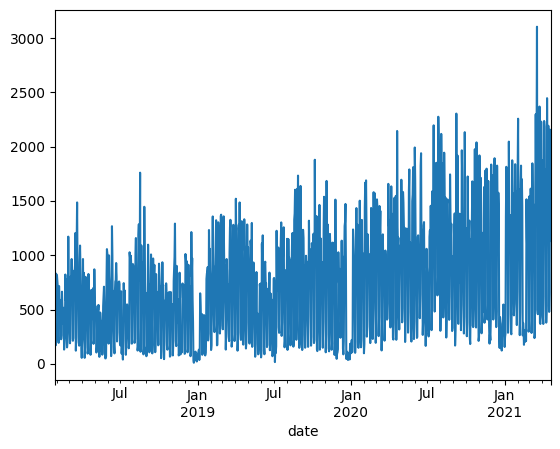

In [12]:
pages.plot()

In [13]:
#use ewm (gets the exponential moving average(EMA)) to smooth out the data (gets rid of the noise in the data) with a span of 7 days
ema_7d = pages.ewm(span=7).mean()
ema_7d

date
2018-01-26     572.000000
2018-01-27     376.571429
2018-01-28     287.243243
2018-01-29     485.737143
2018-01-30     540.235595
                 ...     
2021-04-17    1303.458794
2021-04-18    1142.344096
2021-04-19    1395.758072
2021-04-20    1529.318554
2021-04-21    1429.738915
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [14]:
#get the ema for 14 days
ema_14d = pages.ewm(span=14).mean()
ema_14d

date
2018-01-26     572.000000
2018-01-27     388.785714
2018-01-28     305.208829
2018-01-29     465.757252
2018-01-30     514.347700
                 ...     
2021-04-17    1348.173718
2021-04-18    1256.283889
2021-04-19    1376.246037
2021-04-20    1450.079899
2021-04-21    1407.535912
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [15]:
#get the ema for 30 days
ema_30d = pages.ewm(span=30).mean()
ema_30d

date
2018-01-26     572.000000
2018-01-27     395.300000
2018-01-28     315.139578
2018-01-29     457.002386
2018-01-30     501.369064
                 ...     
2021-04-17    1325.179115
2021-04-18    1282.199817
2021-04-19    1338.574023
2021-04-20    1376.730537
2021-04-21    1360.876954
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [16]:
#get ema for 90 days
ema_90d = pages.ewm(span = 90).mean()
ema_90d

date
2018-01-26     572.000000
2018-01-27     399.100000
2018-01-28     321.030081
2018-01-29     452.545042
2018-01-30     494.228442
                 ...     
2021-04-17    1192.041636
2021-04-18    1180.326435
2021-04-19    1201.769810
2021-04-20    1217.774869
2021-04-21    1215.867729
Freq: D, Name: endpoint, Length: 1182, dtype: float64

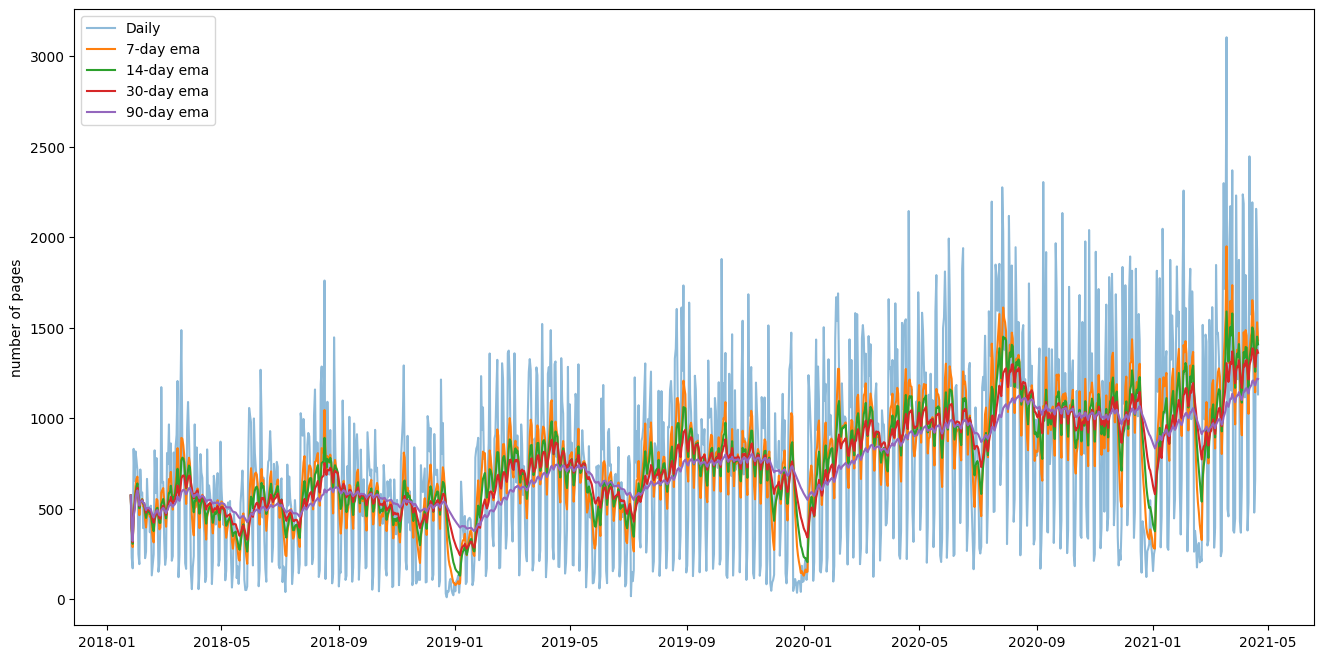

In [18]:
# plot the 7, 14, 30, 90 day ema
fig, ax = plt.subplots(figsize =(16,8))

ax.plot(pages.index, pages, label = 'Daily', alpha = 0.5)

ax.plot(pages.index, ema_7d, label = '7-day ema')
ax.plot(pages.index, ema_14d, label = '14-day ema')
ax.plot(pages.index, ema_30d, label = '30-day ema')
ax.plot(pages.index, ema_90d, label = '90-day ema')

ax.legend(loc = 'best')
ax.set_ylabel('number of pages')

plt.show()

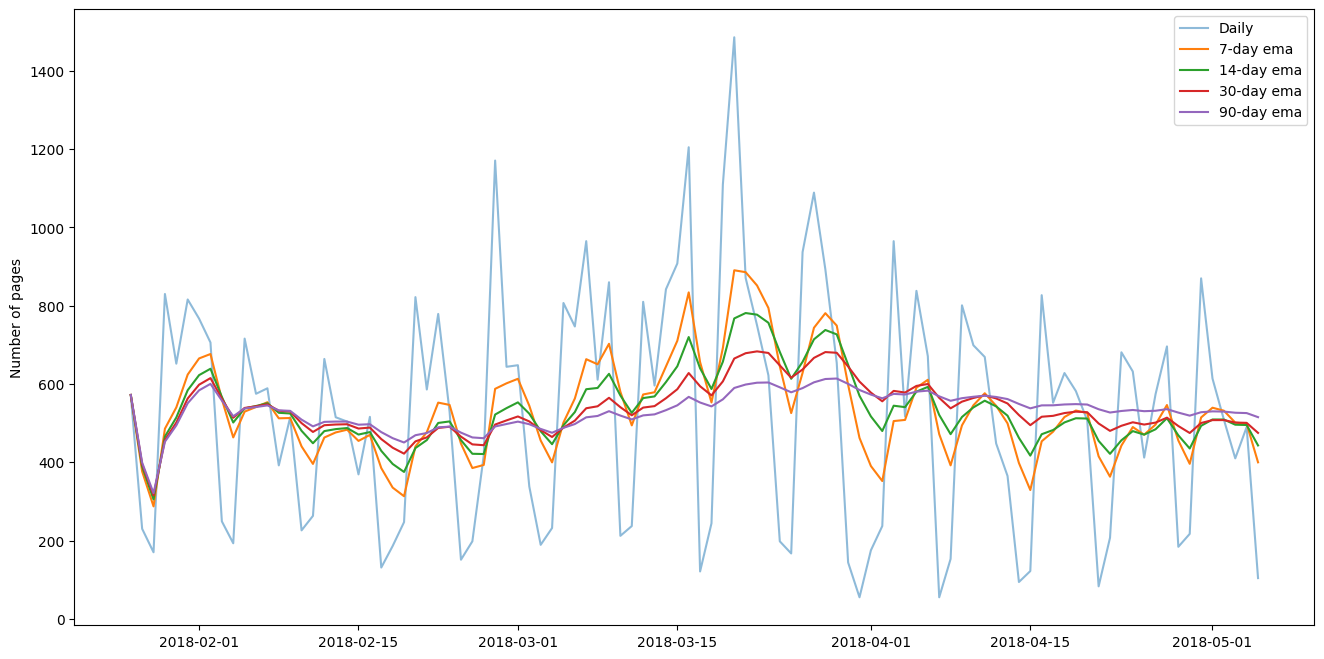

In [20]:
# zoom in the for the first 100 days
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index[:100], pages[:100], label = 'Daily', alpha = 0.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day ema')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day ema')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day ema')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day ema')

ax.legend(loc = 'best')
ax.set_ylabel('Number of pages')

plt.show()

# making bollinger bands
- midband is the exponential moving avaerage
- upper band = Midband + stdev * K
- lower band = Midband - stdev * K
   - K =the number of standard deviation to go up and down from the EMA
   - stdev = train.ewm(spam = 30).std()
- bandwidth
   - the width of the bands
   - bandwidth = (UB - LB)/midband*100
- %b, Percent bandwidth
   - shows where the last value sits in relation to the bands
   - %b = last - LB/UM - LB
       - if %b>1, data point lies above the upper band
       - if %b<0, data point lies below the lower band
       - id %b ==.5, data point lies on the midband

In [21]:
#set the span of days to 30 and K = 3
span = 30
k = 3

In [22]:
# calculate the midband
midband = pages.ewm(span = span).mean()
midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [23]:
# get the std
sd = pages.ewm(span = span).std()
sd.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [24]:
# get the ub and lb
ub = midband + (k* sd)
lb = midband - (k*sd)

In [25]:
ub.head()

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
Freq: D, Name: endpoint, dtype: float64

In [27]:
#combine the midband , ub and lb in to one dataframe 
my_df = pd.concat([pages, midband,lb, ub], axis = 1) # axis =1 to concatenate columns 
my_df.columns = ['pages', 'midband', 'lb', 'ub'] #rename the columns in order of the dataframe
my_df

,pages,midband,lb,ub
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,-330.191557,1120.791557
2018-01-28,170,315.139578,-326.494835,956.773991
2018-01-29,830,457.002386,-492.401124,1406.405897
2018-01-30,652,501.369064,-352.070116,1354.808245
...,...,...,...,...
2021-04-17,478,1325.179115,-894.858492,3545.216722
2021-04-18,659,1282.199817,-922.334061,3486.733695
2021-04-19,2156,1338.574023,-891.999913,3569.147958


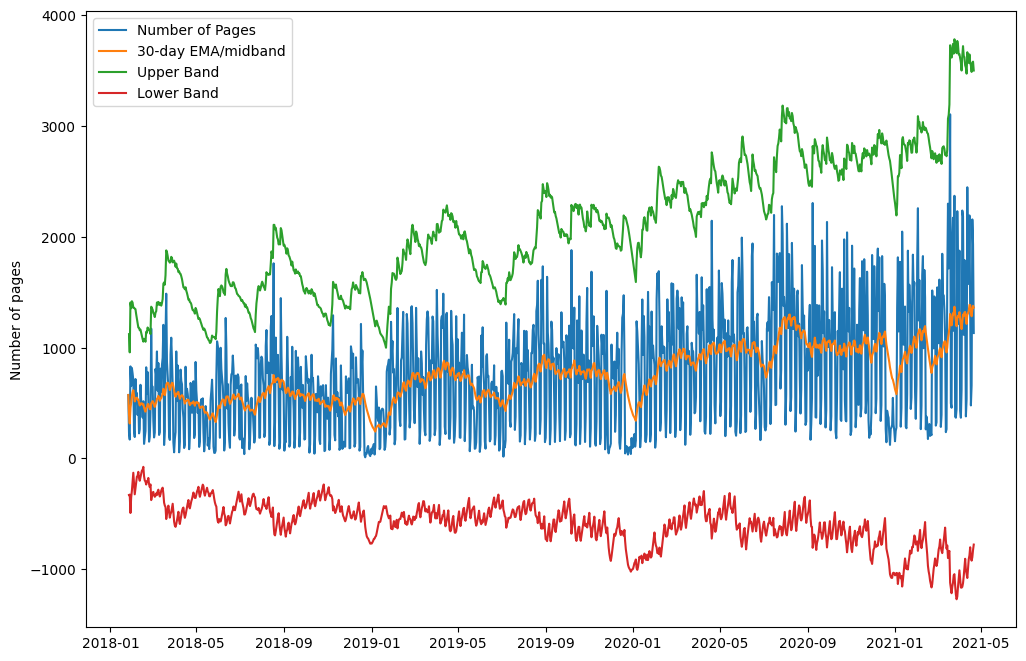

In [28]:
#plot the ub, lb, and midband

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()